# TP1 Redes Neuronales
## Francisco Mendizabal
## Legajo: 61454

In [103]:
# Habilito el helper_fashion.ipynb
%run helper_fashion.ipynb

# En caso que no funcione puedo ver el path del kernel
#import os
#print(os.getcwd())

In [104]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# Carga el dataset
x_data = np.load('train_images.npy')
y_data = pd.read_csv('train_labels.csv').to_numpy().flatten()

# Normaliza cada pixel
x_data = x_data / 255.0

# Separa las imágenes por clase
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_clases = len(class_names)
imagenes_por_clase = [x_data[y_data == clase] for clase in range(num_clases)]    # 10 arreglos de 6k matrices de 28x28

# EDA

### Se realiza un promedio de las imágenes que nos muestra la forma promedio de cada clase, además de su dispersion

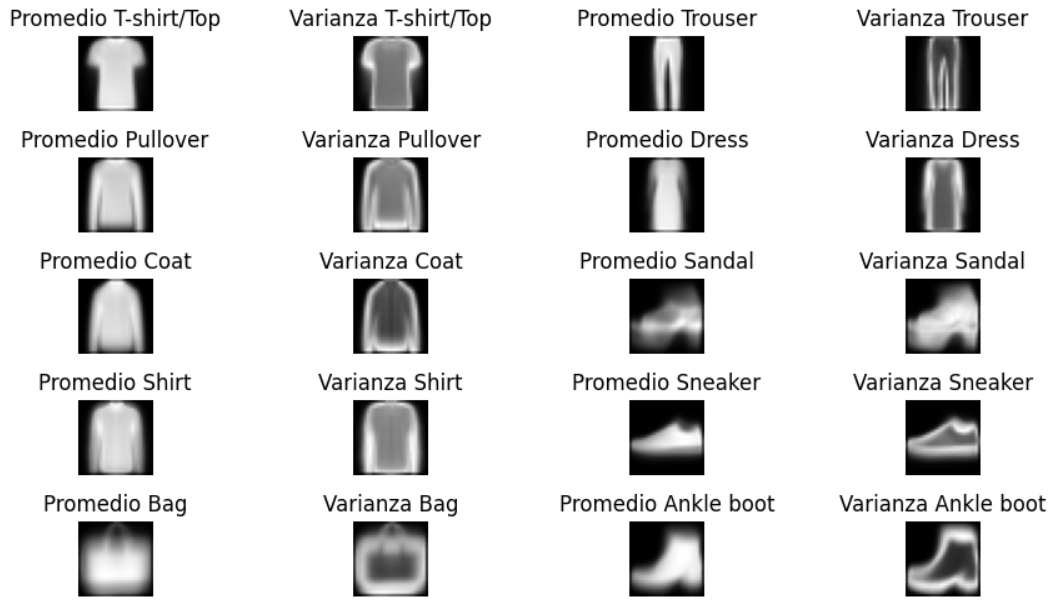

### Algo notable es que las prendas de vestir claramente tienen una orientación predeterminada, por lo cual invertir horizontalmente las imágenes de entrenamiento no nos proporcionaría (en principio) una ventaja a la hora de clasificar

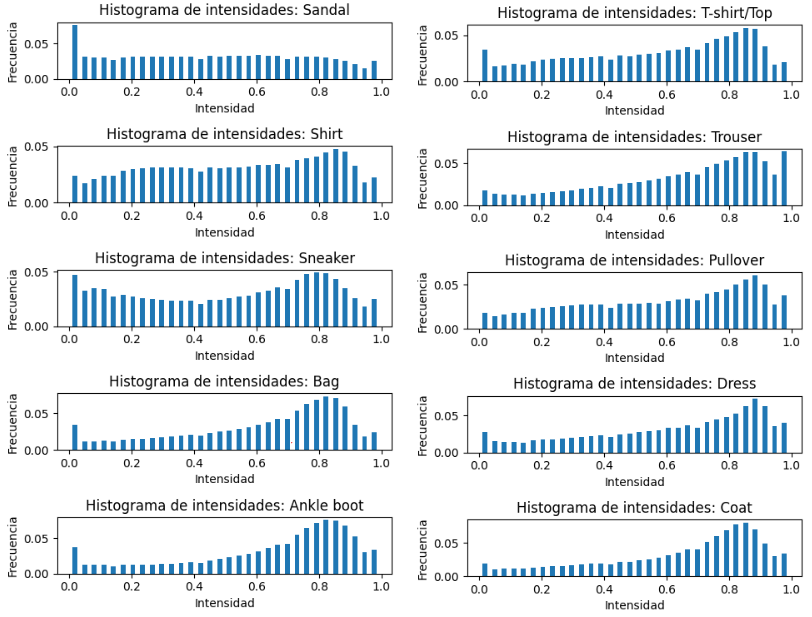

### Los histogramas de intensidad nos muestran que tan similar es la relación de pixeles claros y oscuros entre categorias

### Vemos que muchas de ellas son similares en este sentido, lo cual dificultará la clasificación

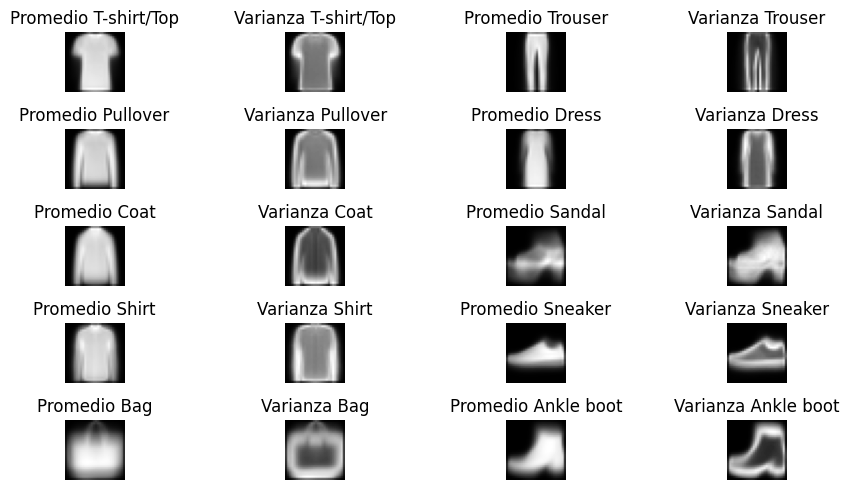

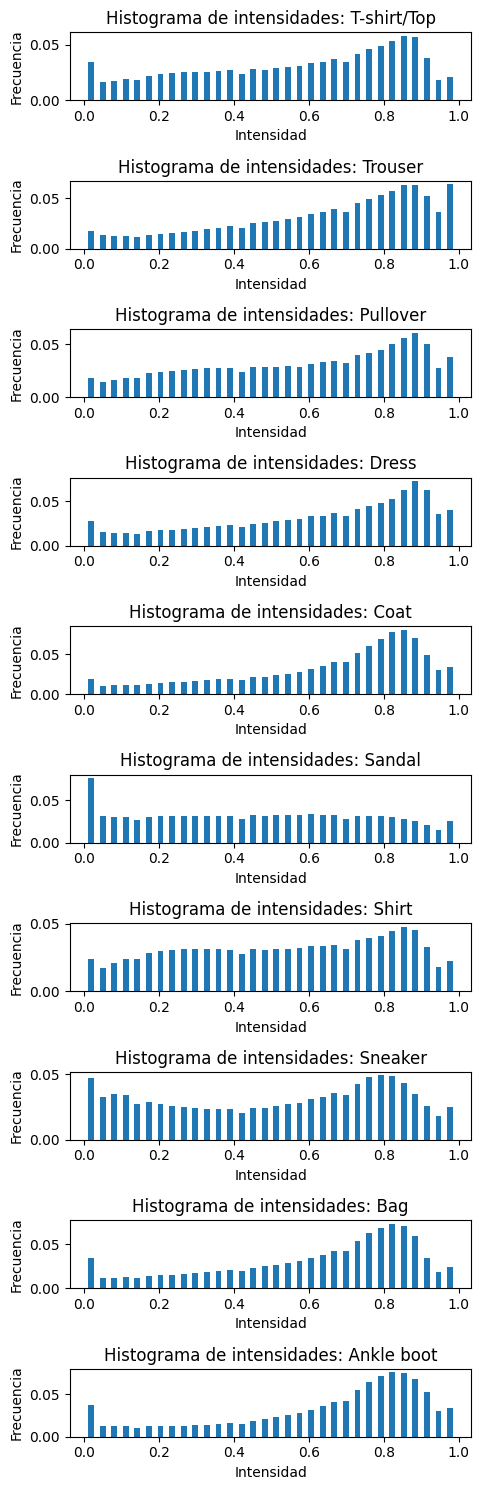

In [105]:
# Calcular el promedio de las imágenes para cada clase
promedio_varianza_ropa(x_data, y_data, num_clases, class_names)

histogramas_de_intensidades(imagenes_por_clase, num_clases, bins_num=32)

# Data Augmentation
### No se observaron mejoras notables al aplicar esto. Por este motivo decido desactivarla

In [106]:
# Elijo si hacer data augmentation
DATA_AUGMENTATION = False

if DATA_AUGMENTATION:
    x_data_augmented, y_data_augmented, imagenes_por_clase_augmented = hf.data_augmentation(x_data, y_data, 
                                                                                     horizontal_flip=False)
    # Grafica algunas imagenes de cada categoría de los dataset aumentados
    hf.plot_data_augmented(imagenes_por_clase_augmented, num_clases, bins=128)

# Keras Tuner
### Se utilizó esta herramienta para determinar un buen conjunto inicial de hiperparámetros

In [107]:
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
import json

NUM_TUNERS = 4
tuners = []
# Instancia/carga los tuner
for n in range(1, NUM_TUNERS):    # en el tuner 0 no use callbacks
    tuners.append(RandomSearch(
        build_model_tuner,
        objective='val_accuracy',
        max_trials=50,
        executions_per_trial=2,
        directory='fashion_mnist_tune',
        project_name=f'tune{n+1}'
    ))

INFO:tensorflow:Reloading Tuner from fashion_mnist_tune\tune2\tuner0.json
INFO:tensorflow:Reloading Tuner from fashion_mnist_tune\tune3\tuner0.json
INFO:tensorflow:Reloading Tuner from fashion_mnist_tune\tune4\tuner0.json


### Ejecucion del Tuner

In [108]:
# Defino los callbacks que voy a utilizar
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.1, min_lr=1e-9)

# Realiza la búsqueda de hiperparámetros
for tuner in tuners[2:]:
    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[early_stop, reduce_lr])

INFO:tensorflow:Oracle triggered exit


### Cargo valores de los Tuner y analizo los resultados

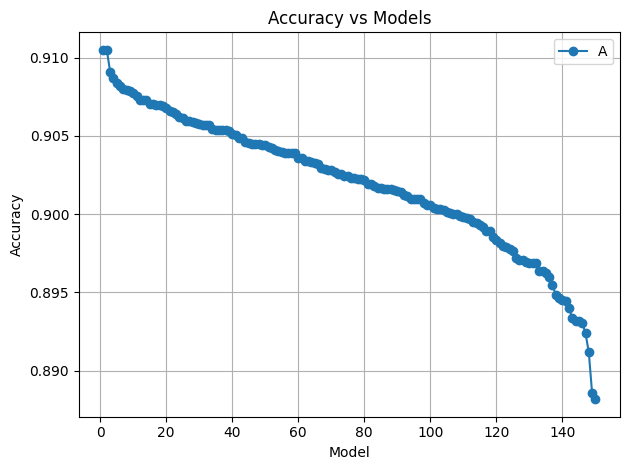

Los modelos son de los tuner [50, 100, 0, 1, 2]
Los accuracy de los mejores modelos son (0.9104999899864197, 0.9104999899864197, 0.9091111123561859, 0.9086666703224182, 0.9083888828754425)
Los batch size de los mejores modelos son (128, 64, 256, 32, 32)


In [125]:
NUM_MODELS = 50

best_trials, best_hps = [], []

for tuner in tuners:
    best_trials.append(tuner.oracle.get_best_trials(num_trials=NUM_MODELS))
    best_hps.append(tuner.get_best_hyperparameters(num_trials=NUM_MODELS))

tuner_batches = [hps.get('batch_size') for trial in best_hps for hps in trial]
tuner_accuracy = [trial.metrics.get_best_value('val_accuracy') for tune in best_trials for trial in tune]
tuner_indices = [n for n in range(len(best_hps) * NUM_MODELS)]

sorted_accuracy, sorted_batches, sorted_indices = zip(*sorted(zip(tuner_accuracy, 
                                                                  tuner_batches, tuner_indices), reverse=True))
flat_best_hps = np.concatenate([hps for hps in best_hps])
plot_tuner_results(sorted_accuracy)

ANALYZED_MODELS = 5
print('Los modelos son de los tuner ' + str([indice for indice in sorted_indices[:ANALYZED_MODELS]]))
print('Los accuracy de los mejores modelos son ' + str(sorted_accuracy[:ANALYZED_MODELS]))
print('Los batch size de los mejores modelos son ' + str(sorted_batches[:ANALYZED_MODELS]))

# Modelos
### Divido en train y validacion

In [110]:
from sklearn.model_selection import train_test_split
from keras import backend as K

if DATA_AUGMENTATION:
    x_train, x_val, y_train, y_val = train_test_split(x_data_augmented, 
                                                      y_data_augmented, test_size=0.15, random_state=27)
else:
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.15, random_state=27)

### Defino los modelos y callbacks a partir del tuner

In [126]:
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import clone_model
from keras import backend as K

K.clear_session()

MODELOS_TUNER = 2
models = []

# Modelo Básico (para analizar Softmax)
aux_model = keras.Sequential()
aux_model.add(Flatten(input_shape=(28, 28), name='layer0_0'))
aux_model.add(Dense(10, activation='softmax', name='layer1_0'))   
aux_model.summary()

models.append(aux_model)

batches = [sorted_batches[0]]      # asigno el mejor batch size a este modelo

del aux_model

# Mejores Modelos del Fitter (analizaré solo el primero)
for n in range(MODELOS_TUNER):

    aux_model = keras.Sequential()
    aux_model.add(Flatten(input_shape=(28, 28), name=f'layer0_{n+1}'))
    
    for layer in range(flat_best_hps[sorted_indices[n]].values['layers']):
        aux_model.add(Dense(flat_best_hps[sorted_indices[n]].values[f'unit_{layer+1}'], activation='relu',
                            kernel_initializer=flat_best_hps[sorted_indices[n]].values[f'initializer_{layer+1}'], 
                            name=f'layer{2*layer+1}_{n+1}'))
        aux_model.add(Dropout(flat_best_hps[sorted_indices[n]].values[f'dropout_{layer+1}'], 
                              name=f'layer{2*(layer+1)}_{n+1}'))
        
    aux_model.add(Dense(10, activation='softmax', name=f'layer{2*flat_best_hps[sorted_indices[n]].values["layers"]+1}_{n+1}')) 
    aux_model.summary()
    
    models.append(clone_model(aux_model))
    batches.append(sorted_batches[n])
    
    del aux_model
    
# Defino los callbacks que voy a utilizar
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=np.sqrt(0.1), min_lr=1e-9)

callbacks = [early_stop, reduce_lr]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0_0 (Flatten)          (None, 784)               0         
                                                                 
 layer1_0 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0_1 (Flatten)          (None, 784)               0         
                                                                 
 layer1_1 (Dense)            (None, 1024)              803840    
                                                                 
 layer2_1 (Dropout)          (No

### Entrenamiento simple de todos los modelos

In [ ]:
from keras.optimizers import Adam

for n in range(0, len(models)):    # modificar extremos si quiero algun modelo en particular
    
    aux_model = clone_model(models[n])
    compile_model(aux_model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, aux_model, batches[n], callbacks)
    
    best_epoch = aux_history.epoch[np.argmax(aux_history.history['val_accuracy'])]
    aux_loss, aux_accuracy = aux_model.evaluate(x_val, y_val)
    
    actual_model = load_model(f'Models_MNIST/model_{n}.h5')
    actual_loss, actual_accuracy = actual_model.evaluate(x_val, y_val)

    if aux_accuracy > actual_accuracy:
        print(f'El modelo {n} mejoró su accuracy de {actual_accuracy} a {aux_accuracy}')
        aux_model.save(f'Models_MNIST/model_{n}.h5', overwrite=True)
        
    del aux_model

### Entrenamiento reiterativo (sirve para la competencia)

In [ ]:
from keras.optimizers import Adam

MIN_ACCURACY = 0.91
loss = MAX_LOSS
accuracy = MIN_ACCURACY

N = 2

# entreno el modelo hasta conseguir la performance obtenida en el tuner    
while(accuracy <= MIN_ACCURACY):    
    
    aux_model = clone_model(models[N])
    compile_model(aux_model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, aux_model, batches[N], callbacks)
    
    loss, accuracy = aux_model.evaluate(x_val, y_val)
    
    if accuracy > MIN_ACCURACY:
        aux_model.save('good_model2.h5')
        
    del aux_model

### Cargo modelos de archivos (aca tengo los mejores)

In [ ]:
import glob
import os
import numpy as np
from keras.models import load_model

N = 1    # modelo que quiero analizar
models = []

folder = 'Models_MNIST'
model_pattern = os.path.join(folder, '*.h5')
model_files = glob.glob(model_pattern)

for file in model_files:
    model = load_model(file)
    models.append(model)

BEST_BATCH_SIZE = 256        # no se guarda en el modelo, guardo un valor que haya dado buenos resultados
batches = np.repeat(BEST_BATCH_SIZE, len(model_files)) 

# Defino los callbacks que voy a utilizar
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=np.sqrt(0.1), min_lr=1e-9)

callbacks = [early_stop, reduce_lr]

### Codigo para generar Submissions de Kaggle

In [ ]:
from keras.models import load_model

x_test = np.load('test_images.npy')
'''
predicts = []
for n in range(1, len(models)):      # excluyo la softmax
    predicts.append(models[n].predict(x_test))
'''
model = load_model('good_model2.h5')
predicts = model.predict(x_test)

In [ ]:
# Genero predicciones del modelo para la competencia
x_test = np.load('test_images.npy')
'''
for n in range(len(predicts)):
    labels = np.array([np.argmax(prediction) for prediction in predicts[n]])
    submission = pd.DataFrame({"id": np.arange(10000), "Category": labels})
    submission.to_csv(f"submission{n+1}.csv", index=False)
'''
labels = np.array([np.argmax(prediction) for prediction in predicts])
submission = pd.DataFrame({"id": np.arange(10000), "Category": labels})
submission.to_csv("submission.csv", index=False)

# Graficos

### Se eligio el mejor modelo generado por el tuner. Además, se utilizaron dos callbacks: early stopping con patience=10 y reduce_on_plateau con patience=3

## Activaciones

### La prueba consistio en modificar la funcion de activacion de todas las capas densas, exceptuando la capa softmax a la salida.
### Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
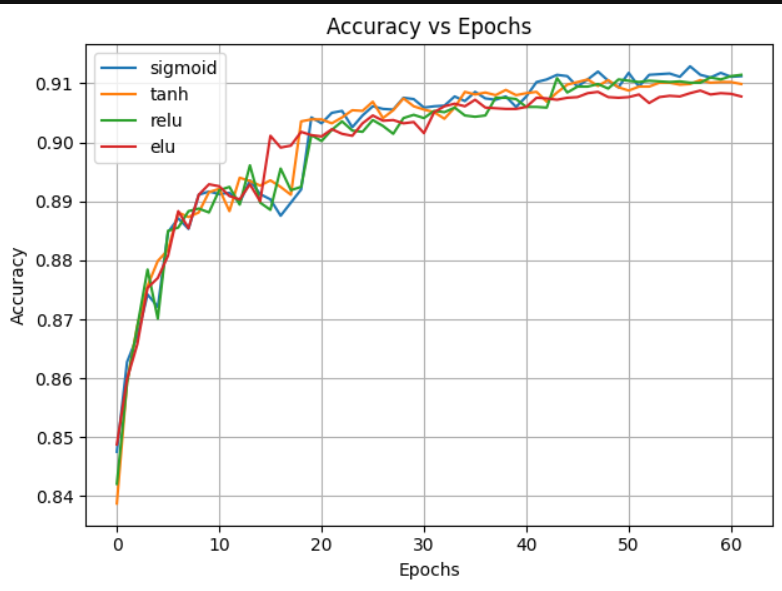

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
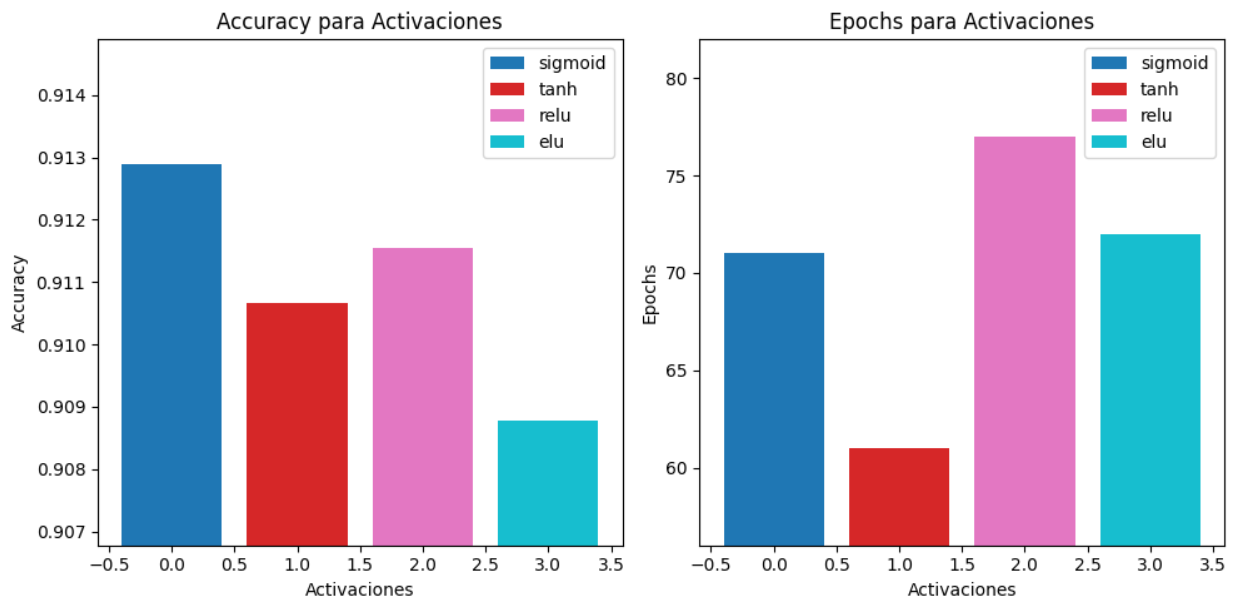

### En general, todas las funciones de activacion tienen una muy buena performance. La unica diferencia notable es la cantidad de epochs necesarias en el caso de la tanh, aunque tampoco es de gran impacto.

In [ ]:
from keras.models import load_model

acts = ['sigmoid', 'tanh', 'relu', 'elu']
accuracies1 = []
epochs1 = []

for act in acts:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    N = 1
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))
    
    # cambio las capas densas (excepto softmax) por otras activaciones
    for layer in model.layers:
        if type(layer) == Dense:
            if layer.activation.__name__ != 'softmax':
                new_layer = Dense(layer.units, activation=act, kernel_initializer=layer.kernel_initializer)
                layer = new_layer

    compile_model(model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)
    accuracies1.append(aux_history.history['val_accuracy'])
    epochs1.append(aux_history.epoch)
    
    del model

plot_acc_vs_epochs(accuracies1, epochs1, acts)
plot_bars(acts, accuracies1, epochs1, 'Activaciones') 

## Inicializadores

### La prueba consistio en modificar los inicializadores en todas las capas densas, incluyendo la softmax. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
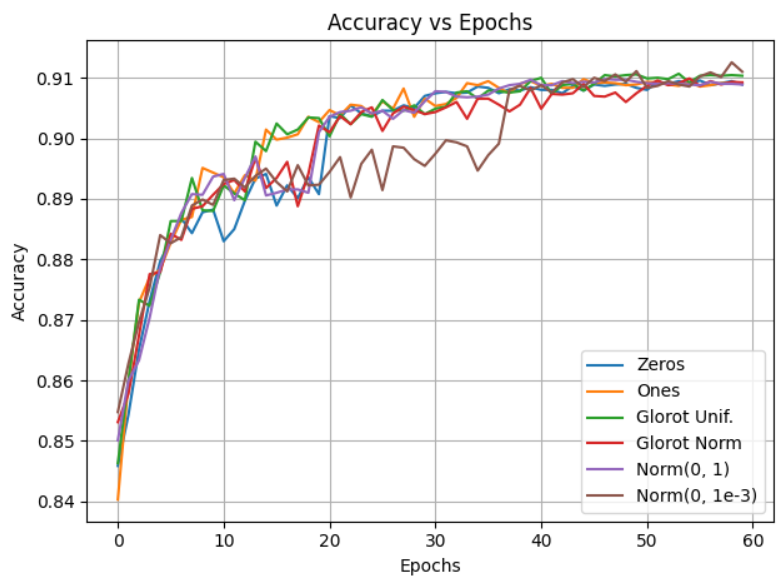

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
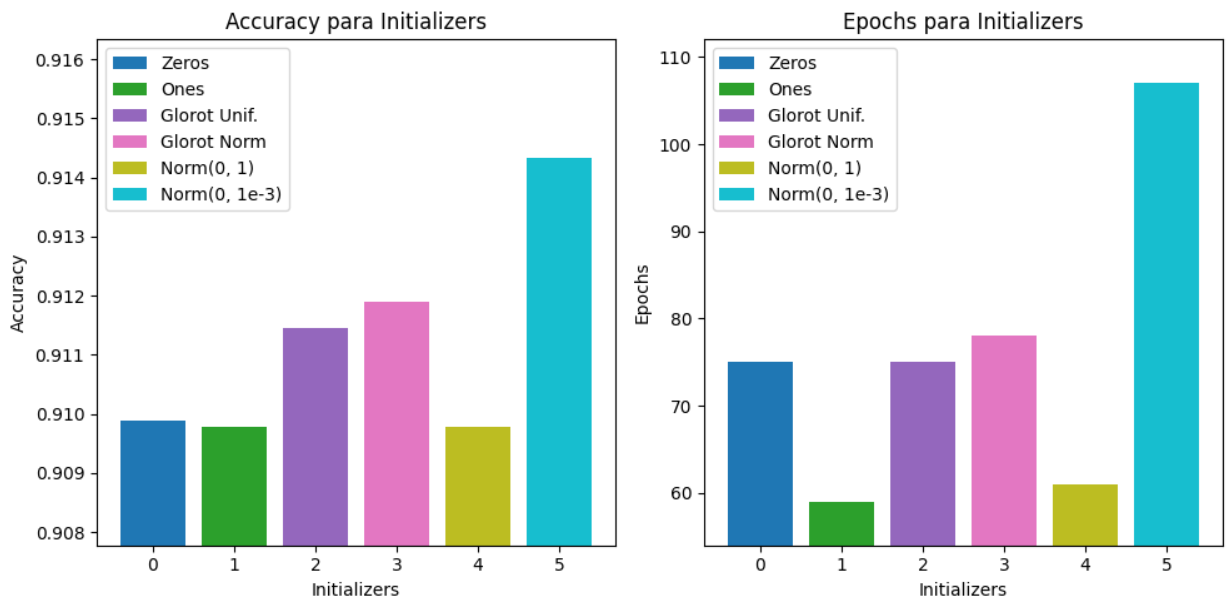

### En general, todos los inicializadores tienen una muy buena performance. La unica diferencia notable ocurre tanto en el accuracy como en la cantidad de epochs requerida por Norm(0, 1e-3).

In [ ]:
from keras.initializers import RandomNormal 

inits = ['zeros', 'ones', 'glorot_uniform', 'glorot_normal', RandomNormal(stddev=1), RandomNormal(stddev=1e-3)]
accuracies2 = []
epochs2 = []

for init in inits:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    N = 1
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))
    
    # cambio los inicializadores en todas las capas densas
    for layer in model.layers:
        if type(layer) == Dense:
            new_layer = Dense(layer.units, activation=layer.activation.__name__, kernel_initializer=init)
            layer = new_layer

    compile_model(model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)
    accuracies2.append(aux_history.history['val_accuracy'])
    epochs2.append(aux_history.epoch)
    
    del model
    
init_labels = ['Zeros', 'Ones', 'Glorot Unif.', 'Glorot Norm', 'Norm(0, 1)', 'Norm(0, 1e-3)']
plot_acc_vs_epochs(accuracies2, epochs2, init_labels)
plot_bars(init_labels, accuracies2, epochs2, 'Initializers')  

## Dropout

### La prueba consistio en modificar el parametro de las capas dropout, luego de cada capa densa (exceptuando la softmax), todas en simultaneo. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
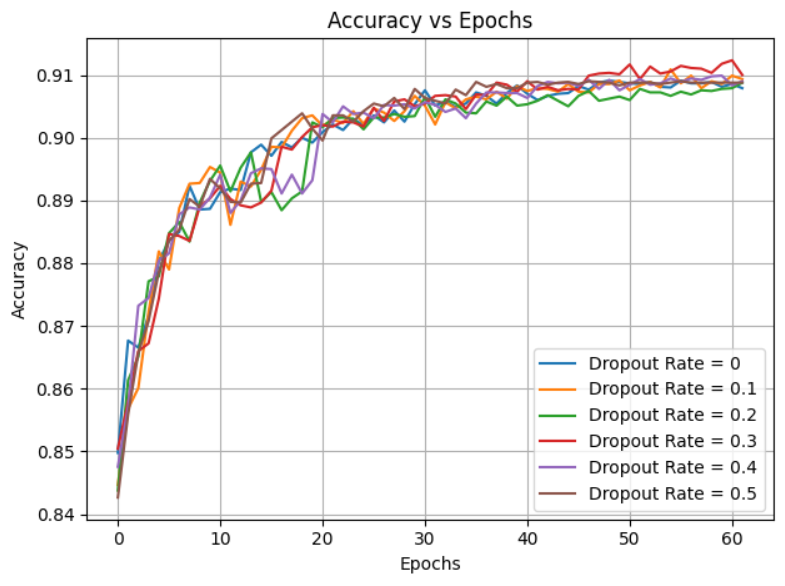

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
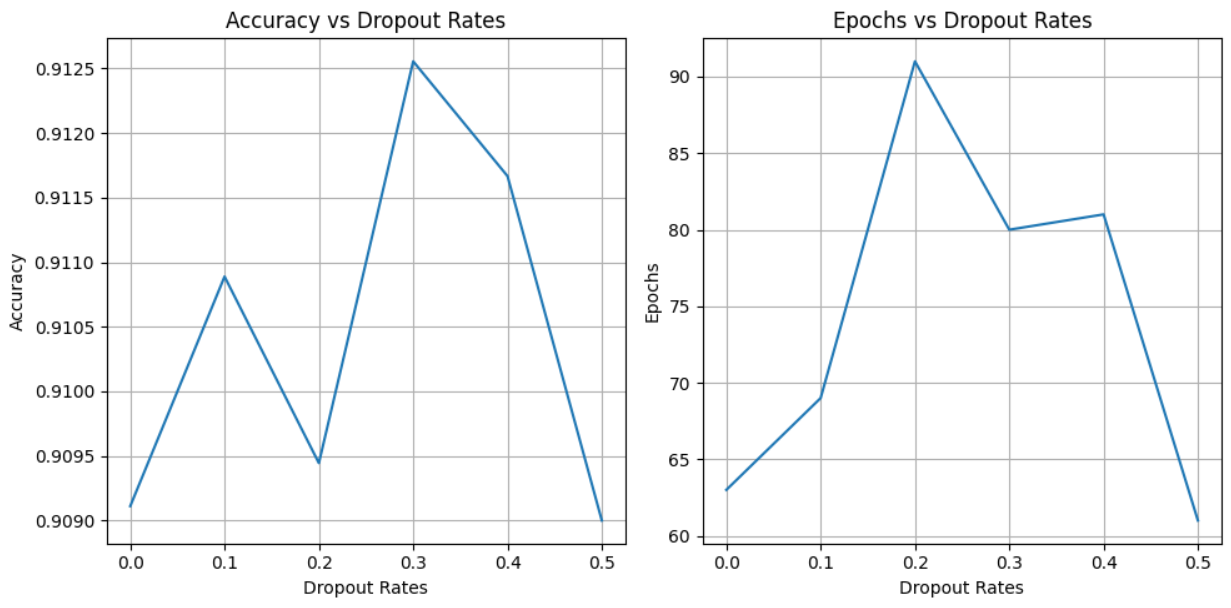

### En general, todas las funciones de activacion tienen una muy buena performance. Si bien 0.3 pareciera ser el valor optimo, las diferencias no son lo suficientemente amplias para confirmarlo.

In [ ]:
drops = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies3 = []
epochs3 = []

for drop in drops:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    N = 1
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))
    
    # cambio los inicializadores en todas las capas densas
    for layer in model.layers:
        if type(layer) == Dropout:
            new_layer = Dropout(drop)
            layer = new_layer

    compile_model(model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)
    accuracies3.append(aux_history.history['val_accuracy'])
    epochs3.append(aux_history.epoch)
    
    del model

plot_acc_vs_epochs(accuracies3, epochs3, ['Dropout Rate = ' + str(drop) for drop in drops])
plot_curves(drops, accuracies3, epochs3, 'Dropout Rates', xscale='linear')  

## Learning Rate

### La prueba consistio en modificar el learning rate del optimizador Adam. Además, se apagó el callback de reduce_on_plateau, dado que si lo utilizaba iba a obtener resultados muy similares en todos los casos. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
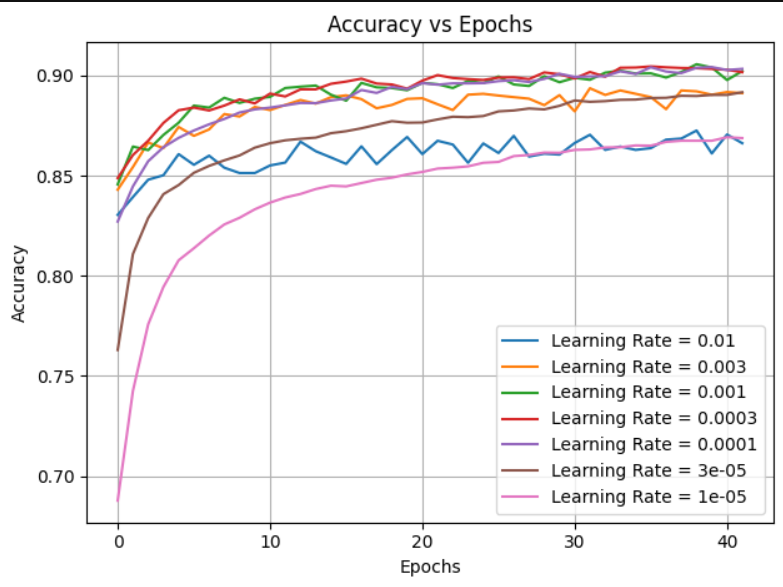

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
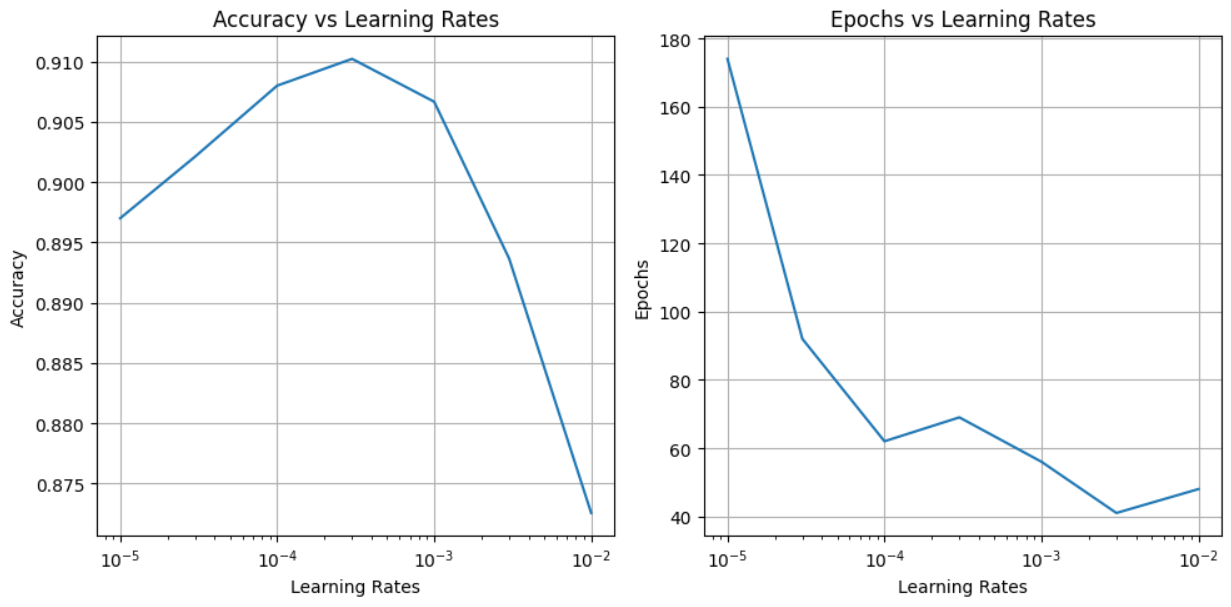

### En este caso las diferencias son mas claras. Un learning rate demasiado alto, no puede superar una cierta barrera en el accuracy. Por el contrario, un learning rate demasiado bajo converge demasiado lento al valor optimo. Debido a que esta activado el early stopping, esto se refleja en un menor accuracy, aunque si se apagara este callback y se dejara corriendo muchas epochs, lo mas probable seria que se alcance un valor similar a los accuracy de los learning rtae intermedios. En conclusíon, un buen accuracy para este caso se encuentra entre 1e-3 y 1e-4.

In [ ]:
lrates = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
accuracies4 = []
epochs4 = []

for lrate in lrates:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    N = 1
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))

    compile_model(model, Adam(learning_rate=lrate))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batches[N], early_stop)
    accuracies4.append(aux_history.history['val_accuracy'])
    epochs4.append(aux_history.epoch)
    
    del model
    
plot_acc_vs_epochs(accuracies4, epochs4, ['Learning Rate = ' + str(lr) for lr in lrates])
plot_curves(lrates, accuracies4, epochs4, 'Learning Rates', xscale='log')  

## Optimizadores

### La prueba consistio en modificar el optimizador, manteniendo un learning rate de 1e-3. Además, se apagó el callback de reduce_on_plateau, para que este no influya en los calculos internos relacionados al learning rate de cada optimzador. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
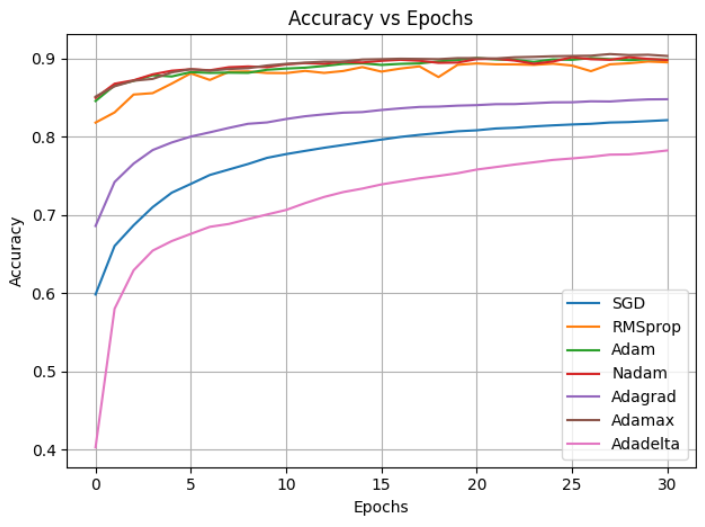

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
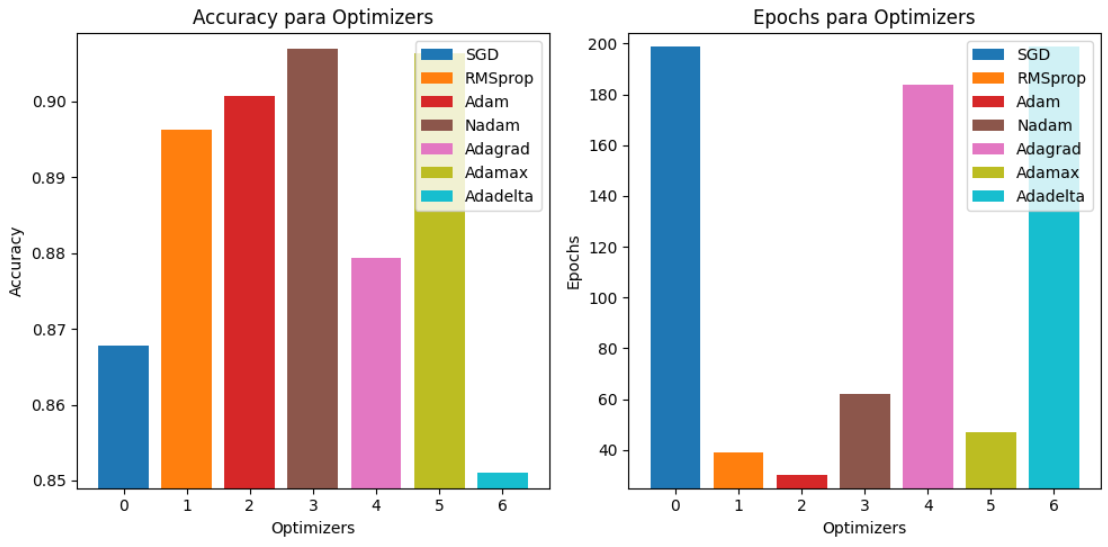

### Se limitó la cantidad de epochs a 200. Debido a ello, SGD y Adadelta no alcanzaron buenos valores de accuracy, ya que estos optimziadores son muy lentos. Por otra parte, Adagrad tampoco lo logró, probablemente debido al early stopping. Además, queda bastante claro que el más rapido de todos es Adam.

In [ ]:
from keras.optimizers import SGD, RMSprop, Adam, Nadam, Adagrad, Adamax, Adadelta

N = 1
opts = [SGD(1e-3), RMSprop(1e-3), Adam(1e-3), Nadam(1e-3), 
        Adagrad(1e-3), Adamax(1e-3), Adadelta(1e-3)]
accuracies5 = []
epochs5 = []

for opt in opts:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))

    compile_model(model, opt)
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batches[N], early_stop)
    accuracies5.append(aux_history.history['val_accuracy'])
    epochs5.append(aux_history.epoch)
    
    del model
    
opt_labels = ['SGD', 'RMSprop', 'Adam', 'Nadam', 'Adagrad', 'Adamax', 'Adadelta']
plot_acc_vs_epochs(accuracies5, epochs5, opt_labels)
plot_bars(opt_labels, accuracies5, epochs5, 'Optimizers')  

## Batch Size

### La prueba consistio en modificar el batch size utilizado. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
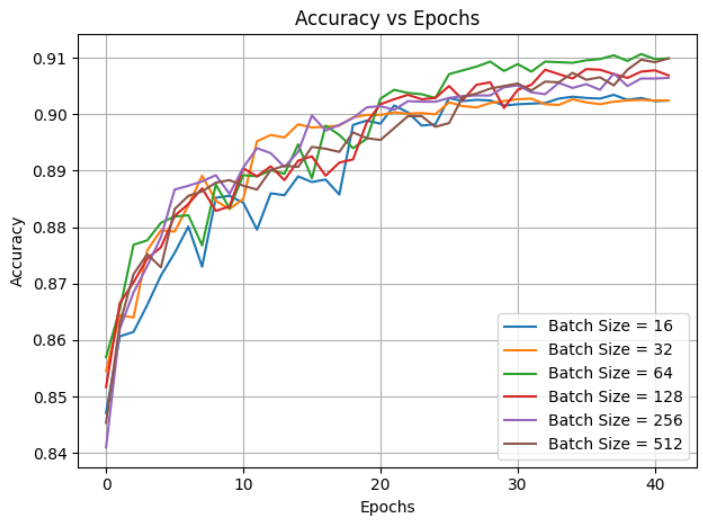

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
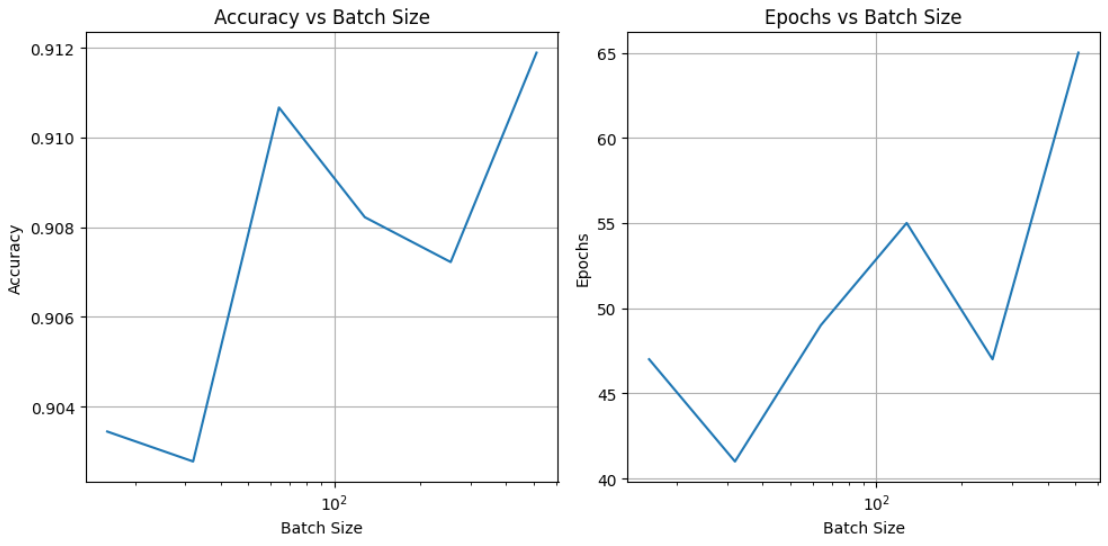

### Vemos que un batch size pequeño tiene una performace ligeramente peor que los mas grandes. Los mejores resultados fueron para batch size entre 64 y 512.

In [ ]:
batches = [16, 32, 64, 128, 256, 512]
accuracies6 = []
epochs6 = []

for batch in batches:
    
    # Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
    N = 1
    model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))

    compile_model(model, Adam(1e-3))
    aux_model, aux_history = train_model(x_train, y_train, x_val, y_val, model, batch, callbacks)
    accuracies6.append(aux_history.history['val_accuracy'])
    epochs6.append(aux_history.epoch)
    
    del model
    
plot_acc_vs_epochs(accuracies6, epochs6, ['Batch Size = ' + str(batch) for batch in batches])
plot_curves(batches, accuracies6, epochs6, 'Batch Size', xscale='log')  

## Batch Normalization

### La prueba consistio en primero utilizar el modelo actual, con dropout luego de cada capa oculta. Despues se reemplaza cada una de estas capas por un batch normalization, dado que vmos en clase que no es conveniente mezclar ambas tecnicas de regularizacion sobre una misma capa. Primero se realiza el grafico de accuracy vs epochs para las primeras epochs en cada caso.
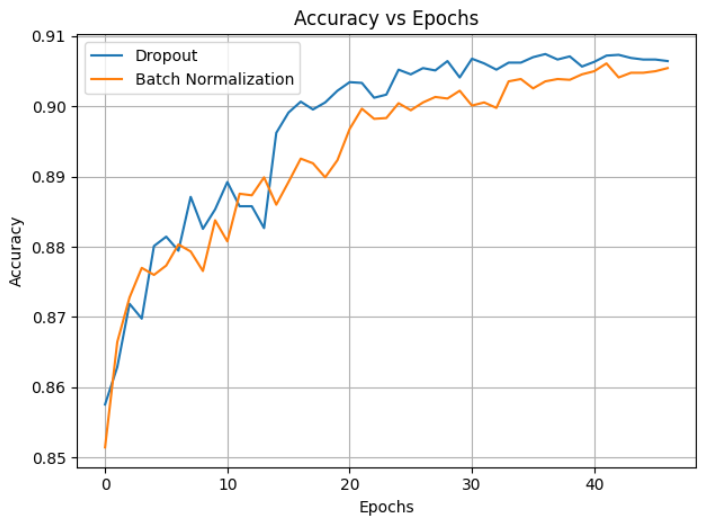

### Luego vemos el accuracy maximo alcanzado en cada caso, y la cantidad de epochs necesarias.
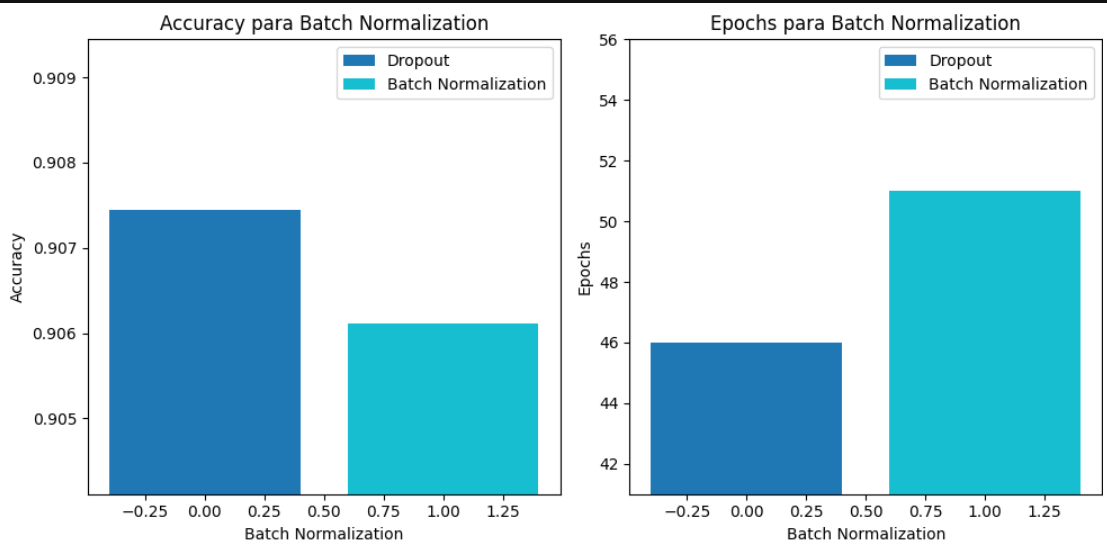

### En ambos casos se obtuvieron resultados similares.

In [ ]:
accuracies7 = []
epochs7 = []
    
# Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
N = 1
model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))

# Con dropouts
compile_model(model, Adam(1e-3))
model, history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)
accuracies7.append(history.history['val_accuracy'])
epochs7.append(history.epoch)

del model

from keras.layers import BatchNormalization

# Cargo el modelo de preferencia y configuro manualmente los hiperparámetros externos al modelo
N = 1
model = clone_model(load_model(f'Models_MNIST/model_{N}.h5'))

# reemplazo dropouts por batch normalizations
for layer in model.layers:
    if type(layer) == Dropout:
        new_layer = BatchNormalization()
        layer = new_layer

compile_model(model, Adam(1e-3))
model, history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)

accuracies7.append(history.history['val_accuracy'])
epochs7.append(history.epoch)

del model

norm_labels = ['Dropout', 'Batch Normalization']
plot_acc_vs_epochs(accuracies7, epochs7, norm_labels)
plot_bars(norm_labels, accuracies7, epochs7, 'Batch Normalization') 

# Metricas

### En microaverage, se calcula la métrica para cada instancia individualmente y luego se promedia sobre todas las instancias. Esto da más peso a las clases con menos instancias, lo cual es útil cuando hay clases minoritarias y se quiere evaluar el desempeño general del modelo teniendo en cuenta todas las instancias por igual, independientemente de la distribución de clases.

### En macroaverage, se calcula la métrica para cada clase individualmente y luego se promedia sobre todas las clases, lo que da igual peso a cada clase. Es útil cuando se desea evaluar el desempeño de cada clase individualmente sin dar más importancia a las clases mayoritarias. Al calcular las métricas para cada clase por separado, el macroaverage permite identificar clases con un rendimiento deficiente o desequilibrios en el modelo. Esto es especialmente relevante cuando se tiene una distribución desigual de las clases y se desea evaluar el desempeño en cada clase de manera equitativa.

### En este caso, se calculan las metricas con macroaverage, dado que nos interesa saber con qué prendas de ropa el modelo funciona mejor. 

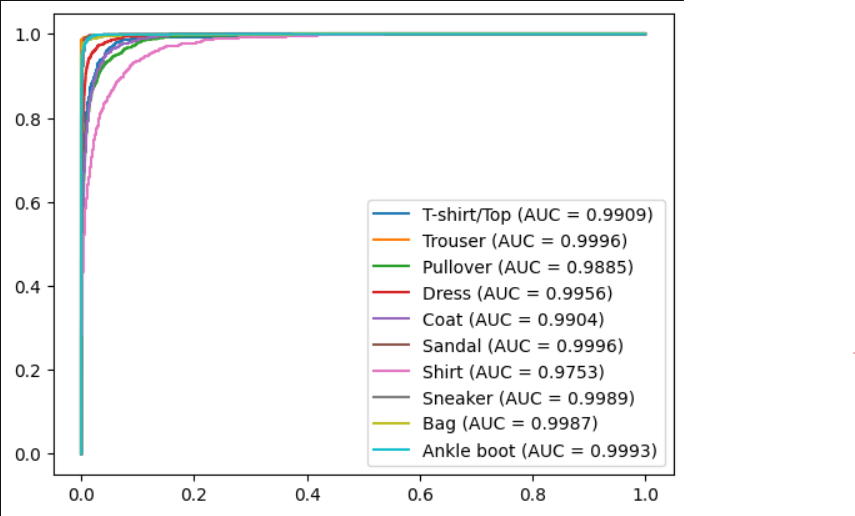

### Vemos que la prenda con el peor rendimiento es "Shirt", seguida de "T-shirt/top", "Coat" y "Pullover". Esto probablemente se deba al parecido entre ellas, ya que en el EDA vemos que la imagen promedio de todas estas categorías es muy similar.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

N = 1
model = load_model(f'Models_MNIST/model_{N}.h5')

# Obtengo las predicciones del modelo
y_predicted = model.predict(x_val)
y_pred = np.argmax(y_predicted, axis=1)   

# Metrica principal
accuracy = accuracy_score(y_val, y_pred)
print('Metrica principal: Accuracy = {:.4f}\n'.format(accuracy))

# Metricas secundarias por clase
f1_scores = f1_score(y_val, y_pred, average=None)
precisions = precision_score(y_val, y_pred, average=None)
recalls = recall_score(y_val, y_pred, average=None)

class_names = [
    'T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

n_classes = y_predicted.shape[1]
auc_scores = []

data = []
for n in range(num_classes):
    data.append({
        "Clase": class_names[n],
        "F1 Score": '{:.4f}'.format(f1_scores[n]),
        "Precision": '{:.4f}'.format(precisions[n]),
        "Recall": '{:.4f}'.format(recalls[n])
    })
print('Metricas secundarias por clase\n')
print(pd.DataFrame(data))

# Calculo el AUC para cada clase
for i in range(n_classes):
    y_true_i = (y_val == i).astype(int)
    y_pred_i = y_predicted[:, i]
    fpr, tpr, _ = roc_curve(y_true_i, y_pred_i)
    auc_score = roc_auc_score(y_true_i, y_pred_i)
    auc_scores.append(auc_score)
    # Trazar la curva ROC para cada clase
    plt.plot(fpr, tpr, label='%s (AUC = %0.4f)' % (class_names[i], auc_score))

plt.legend()

# Metricas secundarias macro
print('\nMetricas secundarias macro\n')
print('F1 Score Macro: %0.4f' % np.mean(f1_scores))
print('Precision Macro: %0.4f' % np.mean(precisions))
print('Recall Macro: %0.4f' % np.mean(recalls))
print('AUC Macro: %0.4f' % np.mean(auc_scores))

# Mapeo de Datos

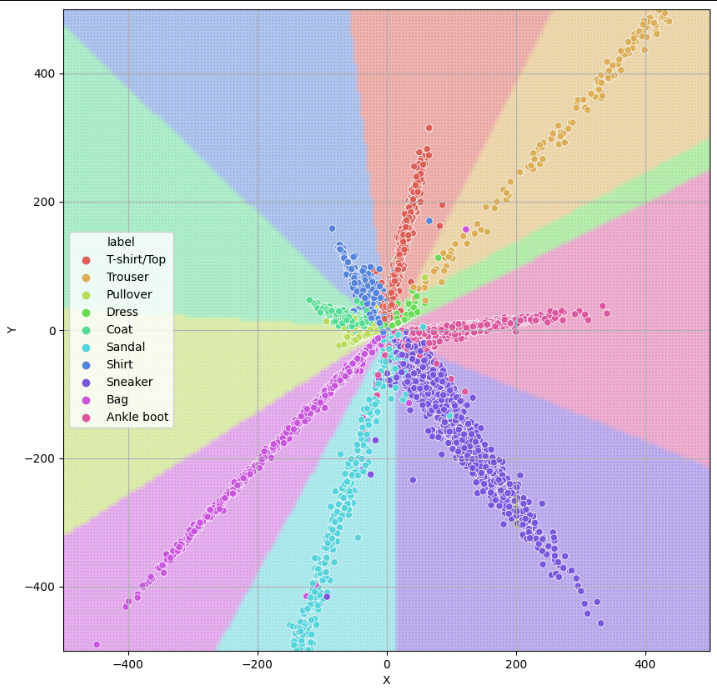

In [ ]:
# Defino los callbacks que voy a utilizar
from keras.models import Model
from keras.optimizers import Adam

callbacks = [early_stop, reduce_lr]

# Entreno el nuevo modelo con la capa de dos neuronas
ref_model = load_model(f'Models_MNIST/model_{N}.h5')

compile_model(model, Adam(learning_rate=(1e-3)))
model, history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)

new_layer = Dense(2, activation='linear')(ref_model.layers[-2].output)

# Primera mitad de la red original 
intermediate_model = Model(inputs=ref_model.input, outputs=new_layer)  

output_layer = Dense(10, activation='softmax')(new_layer)

# Nueva red
model = Model(inputs=intermediate_model.input, outputs=output_layer)

# Nueva capa + softmax
output_model = Model(inputs=new_layer, outputs=model.output)

compile_model(model, Adam(learning_rate=(1e-3)))
model, history = train_model(x_train, y_train, x_val, y_val, model, batches[N], callbacks)

intermediate_output = intermediate_model.predict(x_val)  

intermediate_df = pd.DataFrame()
intermediate_df['zero'] = intermediate_output[:, 0]
intermediate_df['one'] = intermediate_output[:, 1]
results = []
for i in range(intermediate_df.shape[0]):
    results.append(class_names[y_val[i]])  # cargo la clase correspondientes a cada output de la red intermedia
intermediate_df['label'] = results

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Grilla de puntos mapeados
x_min = -5e2
x_max = 5e2
y_min = -5e2
y_max = 5e2
step = 200

x_values = np.linspace(x_min, x_max, num=step)
y_values = np.linspace(y_min, y_max, num=step)

X, Y = np.meshgrid(x_values, y_values)


# Formateo los datos para que sean aptos como inputs a la red de salida
points = np.column_stack((X.flatten(), Y.flatten()))

# Hago las predicciones de la red
out_df = output_model.predict(points)
sparse_df = np.zeros(out_df.shape[0]).astype(int)
for i in range(out_df.shape[0]):
    sparse_df[i] = np.argmax(out_df[i]).astype(int)
    #sparse_df.append(np.argmax(out_df[i]))

# Mapeo cada punto predicho por la red de salida a un label
df = pd.DataFrame()
df['X'] = points[:, 0]
df['Y'] = points[:, 1]
results_df = []
for i in range(df.shape[0]):
    results_df.append(class_names[sparse_df[i]])
df['label'] = results_df

plt.figure(figsize=(10, 10))

sns.scatterplot( x="X", y="Y",
        hue = 'label',
        hue_order = class_names,
        palette=sns.color_palette("hls", 10),
        data=df,
        legend=None,
        alpha=0.2)

sns.scatterplot( x="zero", y="one",
        hue = 'label',
        hue_order = class_names,
        palette=sns.color_palette("hls", 10),
        data=intermediate_df,
        marker="o",    
        legend='full',
        alpha=1)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)